In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from keras.activations import sigmoid
from keras.models import Model ,load_model
from keras.layers import Input, Dense, ConvLSTM2D, Conv2D, Conv1D, MaxPooling2D, Layer, GlobalAveragePooling2D, Reshape, Flatten, BatchNormalization, Bidirectional
from keras.regularizers import L2
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.optimizers.legacy import Adam
from keras.saving import register_keras_serializable
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from scipy.sparse.linalg import cg


2024-06-01 12:36:54.727974: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 12:36:54.746348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 12:36:54.746363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 12:36:54.746374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 12:36:54.750197: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


2024-06-01 12:36:55.768334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 12:36:55.768439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 12:36:55.771131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# dirs
DATA_DIR = "./load.csv"

In [4]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4
# data['Load'] = np.arange(len(data['Load']))


In [5]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [6]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [7]:
data.describe()

,Timestamp,Load
count,35040,35040.000000
mean,2023-07-02 11:52:30,0.363028
min,2023-01-01 00:00:00,0.000000
25%,2023-04-02 05:56:15,0.260656
50%,2023-07-02 11:52:30,0.319672
75%,2023-10-01 17:48:45,0.415574
max,2023-12-31 23:45:00,1.000000
std,NaN,0.145213


In [8]:
"""
!! parameter settings
n_predict: predict steps
height: final height of the image:
            height * 2 if the n_predict <= width,
            height * 2 + 1 if the n_predict > width
width: width of the image
n_days: use past n days historical time series data as input (number of channel)
n_window_shift: the shift interval of sliding window
"""
n_predict = 2
height = 8
width = 12
n_days = 3
n_window_shift = "15min"

In [9]:
class TimeSeriesImageCoder():
    def __init__(
            self,
        X: pd.DataFrame,
        n_predict: int,
        height: int,
        width: int,
        n_days: int,
        n_window_shift: str
    ) -> None:
        self.X = X
        self.h = height
        self.m = width
        self.d_b = n_days
        self.shift = n_window_shift
        self.n_predict = n_predict
        self.Lb = self.h * self.m
        self.Ls = math.ceil(self.n_predict / self.m) * self.m
        self.timestamps = self.generate_timestamps()
        print(f"Lb: {self.Lb}")
        print(f"Ls: {self.Ls}")

    def generate_timestamps(self):
        start = self.X['Timestamp'].min() + DateOffset(days=3)
        end = self.X['Timestamp'].max() - DateOffset(minutes=96*15)
        timestamps = pd.date_range(start=start, end=end, freq=self.shift)
        return timestamps
    
    def __symmetric_ud(self, vector):
        symmetric_matrices = []
    
        for i in range(0, self.d_b*96, 96):
            day_data = vector[i:i+96]
            day_data_reshaped = np.reshape(day_data, (self.h, self.m))
            symmetric_matrix = np.vstack((day_data_reshaped, np.flipud(day_data_reshaped)))
            symmetric_matrices.append(symmetric_matrix)
        
        return symmetric_matrices

    def __symmetric_lr(self, vector):
        symmetric_matrices = []
    
        for i in range(0, self.d_b*96, 96):
            day_data = vector[i:i+96]
            day_data_reshaped = np.reshape(day_data, (self.h, self.m))
            symmetric_matrix = np.hstack((day_data_reshaped, np.fliplr(day_data_reshaped)))
            symmetric_matrices.append(symmetric_matrix)
        
        return symmetric_matrices


    def encode_b(self):
        training_sets = []
        target_sets = []
        self.X_timeseries_flatten = []
        self.X_timestamp = []
        self.y_timestamp = []
        for steps in self.timestamps:
            training_start_b = steps - DateOffset(days=self.d_b-1, hours=23, minutes=45)
            training_end = steps
            target_start = training_end + DateOffset(minutes=15)
            target_end = steps + DateOffset(minutes=(self.n_predict)*15)
            training_data = self.X[(self.X['Timestamp'] >= training_start_b) & (self.X['Timestamp'] <= training_end)]
            target_data = self.X[(self.X['Timestamp'] >= target_start) & (self.X['Timestamp'] <= target_end)]
            if not training_data.empty and not target_data.empty:
                self.X_timeseries_flatten.append(training_data['Load'])
                self.X_timestamp.append(training_data['Timestamp'])
                self.y_timestamp.append(target_data['Timestamp'])
                # training_reshaped = np.array(training_data['Load']).reshape(self.d_b, self.h, self.m)
                training_reshaped = self.__symmetric_ud(training_data['Load'])
                training_sets.append(training_reshaped)
                target_reshaped = np.array(target_data['Load']).reshape(math.ceil(self.n_predict/self.m), min(self.n_predict, self.m))
                target_sets.append(target_reshaped.flatten())
        training_sets = np.array(training_sets)
        target_sets = np.array(target_sets)

        self.X_timeseries_flatten = np.array(self.X_timeseries_flatten)
        self.X_timestamp = np.array(self.X_timestamp)
        self.y_timestamp = np.array(self.y_timestamp)
        return training_sets, target_sets
    
    def encode(self):
        training_sets_b, target_sets = self.encode_b()
        training_sets_b = np.transpose(training_sets_b, (0, 2, 3, 1))
        return training_sets_b, target_sets
    
    


In [10]:
encoder = TimeSeriesImageCoder(
    X=data,
    n_predict=n_predict,
    height=height,
    width=width,
    n_days=n_days,
    n_window_shift=n_window_shift
)
encoded_Xb, encoded_y = encoder.encode()
X_timeseries = np.copy(encoder.X_timeseries_flatten)
X_timestamp = np.copy(encoder.X_timestamp)
y_timestamp = np.copy(encoder.y_timestamp)

Lb: 96
Ls: 12


In [11]:
print(encoded_Xb.shape)
print(encoded_y.shape)

print(X_timeseries.shape)
print(X_timestamp.shape)
print(y_timestamp.shape)

(34656, 16, 12, 3)
(34656, 2)
(34656, 288)
(34656, 288)
(34656, 2)


In [12]:
MONTH_TIME_STEP = math.floor(encoder.timestamps.shape[0] / 24)
X_test_b = []
y_test = []
X_test_b_flatten = []
X_test_b_timestamp = []
y_test_timestamp = []

for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test_b.append(encoded_Xb[start:end])
    y_test.append(encoded_y[start:end])
    X_test_b_flatten.append(X_timeseries[start:end])
    X_test_b_timestamp.append(X_timestamp[start:end])
    y_test_timestamp.append(y_timestamp[start:end])


    encoded_Xb = np.concatenate([encoded_Xb[:start], encoded_Xb[end:]])
    encoded_y = np.concatenate([encoded_y[:start], encoded_y[end:]])
    X_timeseries = np.concatenate([X_timeseries[:start], X_timeseries[end:]])
    X_timestamp = np.concatenate([X_timestamp[:start], X_timestamp[end:]])
    y_timestamp = np.concatenate([y_timestamp[:start], y_timestamp[end:]])


In [13]:
 
X_test_b = np.concatenate([i for i in X_test_b])
y_test = np.concatenate([i for i in y_test])
X_test_b_flatten = np.concatenate([i for i in X_test_b_flatten])
X_test_b_timestamp = np.concatenate([i for i in X_test_b_timestamp])
y_test_timestamp = np.concatenate([i for i in y_test_timestamp])




In [14]:
X_train_b = encoded_Xb
y_train = encoded_y

In [15]:
print(np.array(X_train_b).shape)
print(np.array(X_test_b).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)
print(X_test_b_flatten.shape)
print(X_test_b_timestamp.shape)
print(y_test_timestamp.shape)

(30048, 16, 12, 3)
(4608, 16, 12, 3)
(30048, 2)
(4608, 2)
(4608, 288)
(4608, 288)
(4608, 2)


<Axes: >

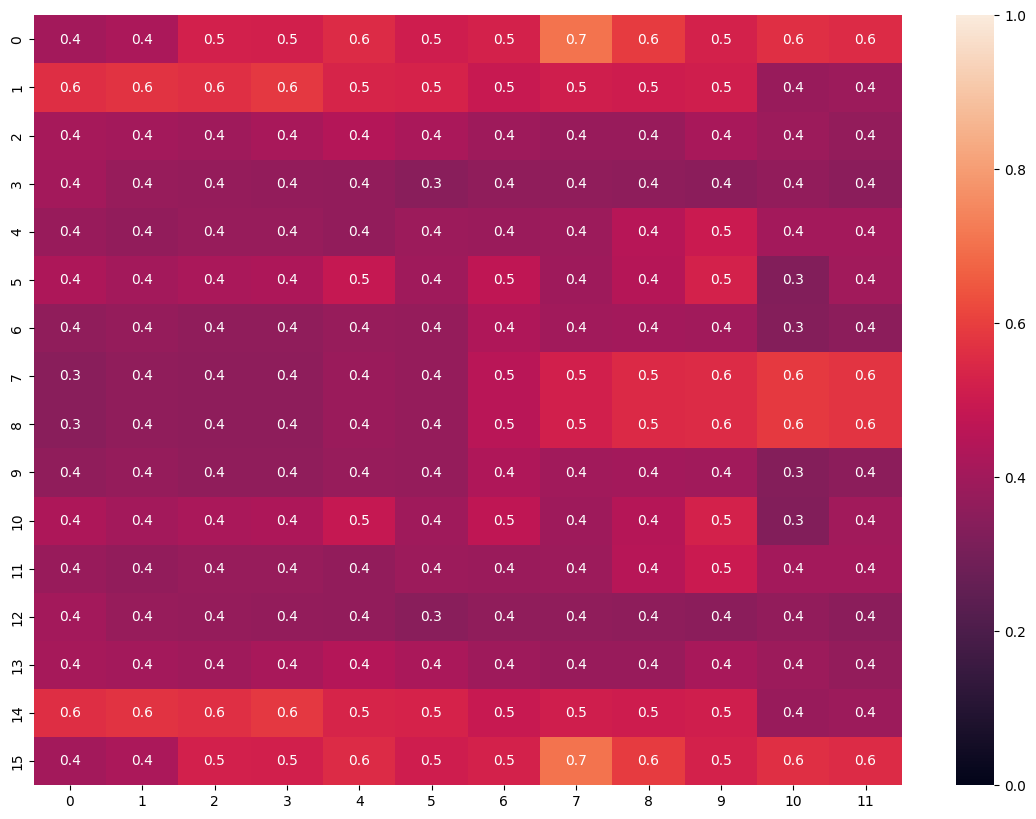

In [16]:
plt.figure(figsize=(14, 10))
sns.heatmap(X_train_b[1000, :, :, 0], vmin=0, vmax=1, annot=True, fmt=".1f")

In [17]:
@register_keras_serializable('ECALayer')
class ECALayer(Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        c = input_shape[-1]
        self.t = max(1, int(abs((tf.math.log(float(c)) / tf.math.log(2.0) + self.b) / self.gamma)))
        self.conv = Conv1D(filters=1, kernel_size=self.t, padding='same', use_bias=False)
        super(ECALayer, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling over the spatial dimensions to produce a (batch_size, 1, channels) tensor
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, -1))(x)
        x = self.conv(x)
        x = sigmoid(x)
        x = tf.squeeze(x, axis=1)  # Squeeze to make it (batch_size, channels)
        
        # Multiply weights across channels
        return inputs * x[:, tf.newaxis, tf.newaxis, :]

    def get_config(self):
        config = super(ECALayer, self).get_config()
        config.update({
            'gamma': self.gamma,
            'b': self.b
        })
        return config

In [18]:
def create_model(input_shape_b, encoder):
    height, width = math.ceil(encoder.n_predict / encoder.m), min(encoder.n_predict, encoder.m)
    inputs_b = Input(shape=input_shape_b)
    conv1 = Conv2D(filters=32, kernel_size=3, padding="same", activation="tanh")(inputs_b)
    conv2 = Conv2D(filters=64, kernel_size=3, padding="same", activation="tanh")(conv1)
    conv2 = Reshape((1, *conv2.shape[1:]))(conv2)
    nor1 = BatchNormalization()(conv2)
    lstm1 = Bidirectional(ConvLSTM2D(filters=96, kernel_size=3, padding="same", activation="tanh", return_sequences=True, dropout=0.0))(nor1)
    nor2 = BatchNormalization()(lstm1)
    lstm2 = Bidirectional(ConvLSTM2D(filters=96, kernel_size=3, padding="same", activation="tanh", return_sequences=False, dropout=0.0))(nor2)
    nor3 = BatchNormalization()(lstm2)
    eca1 = ECALayer()(nor3)
    nor4 = BatchNormalization()(eca1)
    conv3 = Conv2D(filters=64, kernel_size=3, padding="same", activation="tanh")(nor4)
    conv4 = Conv2D(filters=32, kernel_size=3, padding="same", activation="tanh")(conv3)
    nor5 = BatchNormalization()(conv4)
    maxpool1 = MaxPooling2D(pool_size=10, padding="same")(nor5)
    flatten1 = Flatten()(maxpool1)
    outputs = Dense(height*width, activation="linear")(flatten1)
    print(height*width)
    model = Model(inputs=inputs_b, outputs=outputs)

    return model

In [19]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%load_ext tensorboard

tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
early_stopping_callback = EarlyStopping(monitor="loss", patience=10, min_delta=5e-5)
reduce_lr_callback = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=5, verbose=1, min_lr=1e-7)
callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback]
model = create_model(input_shape_b=X_train_b.shape[1:], encoder=encoder)
model.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")
model.summary()

2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 12, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 12, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 12, 64)        18496     
                                                                 
 reshape (Reshape)           (None, 1, 16, 12, 64)     0         
                                                                 
 batch_normalization (Batch  (None, 1, 16, 12, 64)     256       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 1, 16, 12, 192)    1106688   
 al)                                                       

In [20]:
history = model.fit(
    X_train_b,
    y_train,
    verbose=1,
    epochs=120,
    batch_size=96,
    callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback]
)

Epoch 1/120


2024-06-01 12:37:24.450136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/bidirectional_1/forward_conv_lstm2d_1/while/model/bidirectional_1/forward_conv_lstm2d_1/while_grad/body/_753/input/_2066' -> 'gradient_tape/model/bidirectional_1/forward_conv_lstm2d_1/while/model/bidirectional_1/forward_conv_lstm2d_1/while_grad/body/_753/gradient_tape/model/bidirectional_1/forward_conv_lstm2d_1/while/gradients/AddN', 'Func/gradient_tape/model/bidirectional_1/backward_conv_lstm2d_1/while/model/bidirectional_1/backward_conv_lstm2d_1/while_grad/body/_948/input/_2185' -> 'gradient_tape/model/bidirectional_1/backward_conv_lstm2d_1/while/model/bidirectional_1/backward_conv_lstm2d_1/while_grad/body/_948/gradient_tape/model/bidirectional_1/backward_conv_lstm2d_1/while/gradients/AddN', 'Func/gradient_tape/model/bidirectional/backward_conv_lstm2d/while/mod

313/313 [==============================] - 30s 87ms/step - loss: 0.0927 - lr: 5.0000e-05
Epoch 2/120
313/313 [==============================] - 27s 87ms/step - loss: 0.0067 - lr: 5.0000e-05
Epoch 3/120
313/313 [==============================] - 27s 87ms/step - loss: 0.0047 - lr: 5.0000e-05
Epoch 4/120
313/313 [==============================] - 28s 88ms/step - loss: 0.0038 - lr: 5.0000e-05
Epoch 5/120
313/313 [==============================] - 28s 89ms/step - loss: 0.0033 - lr: 5.0000e-05
Epoch 6/120
313/313 [==============================] - 28s 89ms/step - loss: 0.0030 - lr: 5.0000e-05
Epoch 7/120
313/313 [==============================] - 28s 89ms/step - loss: 0.0028 - lr: 5.0000e-05
Epoch 8/120
313/313 [==============================] - 28s 89ms/step - loss: 0.0026 - lr: 5.0000e-05
Epoch 9/120
313/313 [==============================] - 28s 89ms/step - loss: 0.0025 - lr: 5.0000e-05
Epoch 10/120
313/313 [==============================] - 28s 89ms/step - loss: 0.0023 - lr: 5.0000e-05
E

In [21]:
y_pred = model.predict([X_test_b])

  9/144 [>.............................] - ETA: 0s 

2024-06-01 13:10:51.164554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/Tanh_1' -> 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/mul_5', 'Func/model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/input/_288' -> 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/mul_2', 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/convolution_7' -> 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/add_6', 'model/bidirectional_1/backward_conv_lstm2d_1/while/body/_145/model/bidirectional_1/backward_conv_lstm2d_1/while/con

144/144 [==============================] - 1s 8ms/step


In [22]:
print(y_test.shape)
print(y_pred.shape)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape: {mape: .4f}')
print(f'r2: {r2:.4f}')
print("-" * 86)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)


mse_inv = mean_squared_error(y_test_inv, y_pred_inv)
rmse_inv = math.sqrt(mse_inv)
mae_inv = mean_absolute_error(y_test_inv, y_pred_inv)
mape_inv = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
r2_inv = r2_score(y_test_inv, y_pred_inv)

print("-" * 86)
print(f'mse_inv: {mse_inv:.4f}')
print(f'rmse_inv: {rmse_inv:.4f}')
print(f'mae_inv: {mae_inv:.4f}')
print(f'mape_inv: {mape_inv: .4f}')
print(f'r2_inv: {r2_inv:.4f}')
print("-" * 86)

(4608, 2)
(4608, 2)
--------------------------------------------------------------------------------------
mse: 0.0026
rmse: 0.0508
mae: 0.0339
mape:  0.0944
r2: 0.8913
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
mse_inv: 24.5525
rmse_inv: 4.9551
mae_inv: 3.3134
mape_inv:  0.0941
r2_inv: 0.8913
--------------------------------------------------------------------------------------


In [ ]:
model.save("./model/image_symmetric_ud_16_12.keras") 